<a href="https://colab.research.google.com/github/piyushhhsharmaaa/Visitor-Analysis/blob/main/Visitor_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Executive Summary

**Business Problem:** The goal is to boost customer satisfaction at our theme parks by analyzing visitor feedback. Identifying areas for improvement and strengths will help us enhance service quality and operational efficiency, increasing visitor satisfaction and loyalty.

**Proposed Approaches:**

1. **Sentiment Analysis:** We categorized reviews into positive, negative, and neutral sentiments to gauge overall satisfaction and feedback on services, detailed in Section 3.

2. **Topic Modeling:** Latent Dirichlet Allocation (LDA) identified recurring themes in reviews, discussed in Section 4, revealing prevalent concerns and interests.

3. **Data Visualization:** Visualization techniques illustrated sentiment and topic distributions, covered in Section 2, aiding in understanding customer feedback trends.

4. **Data Exploration:** Exploratory analysis of visitor demographics and seasonal patterns, also in Section 2, provided deeper insights into preferences and pain points.

**Major Findings:**

1. **Sentiment Analysis:** California had the highest sentiment score, reflecting superior satisfaction. Paris received the most positive feedback on services.

2. **Topic Modeling Insights:** Key themes include wait times, family experiences, and service quality, identifying both areas for improvement and strengths.

3. **Visitor Trends:** Section 2 reveals differences in visitor origins and seasonal patterns, useful for targeted marketing and planning.




<a id = "cell_exploration"></a>
# **2. Data Exploration**

**Aim**: To demonstrate an understanding of the data and report insights emerging from the data analysis.


In [ ]:
!pip install gensim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
from textblob import TextBlob
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
from gensim import corpora
from gensim.models import LdaModel


from google.colab import drive
drive.mount('/content/drive/')
file_path = '/content/drive/My Drive/ThemeParkReviews.csv'
data = pd.read_csv(file_path)
data.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,Review_ID,Year_Month,Reviewer_Location,Review_Text,Branch
0,148524565,2012-12,United States,"Loved seeing the Christmas lights at the park,...",California
1,346403028,2015-3,United States,I'm not sure reviewing Disneyland even has a p...,California
2,284580024,2015-6,United States,Went to Disneyland for one day. We arrive at o...,California
3,410306562,2015-12,Canada,I travelled to Disneyland from Toronto in Dece...,California
4,358484811,2015-7,United States,This place might be ok for families with kids....,California


### A. Visitor Distribution by Location

/tmp/ipython-input-3957764969.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_visitors = visitor_counts.groupby('Branch').apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)
/tmp/ipython-input-3957764969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Reviewer_Location', data=data, palette='viridis')


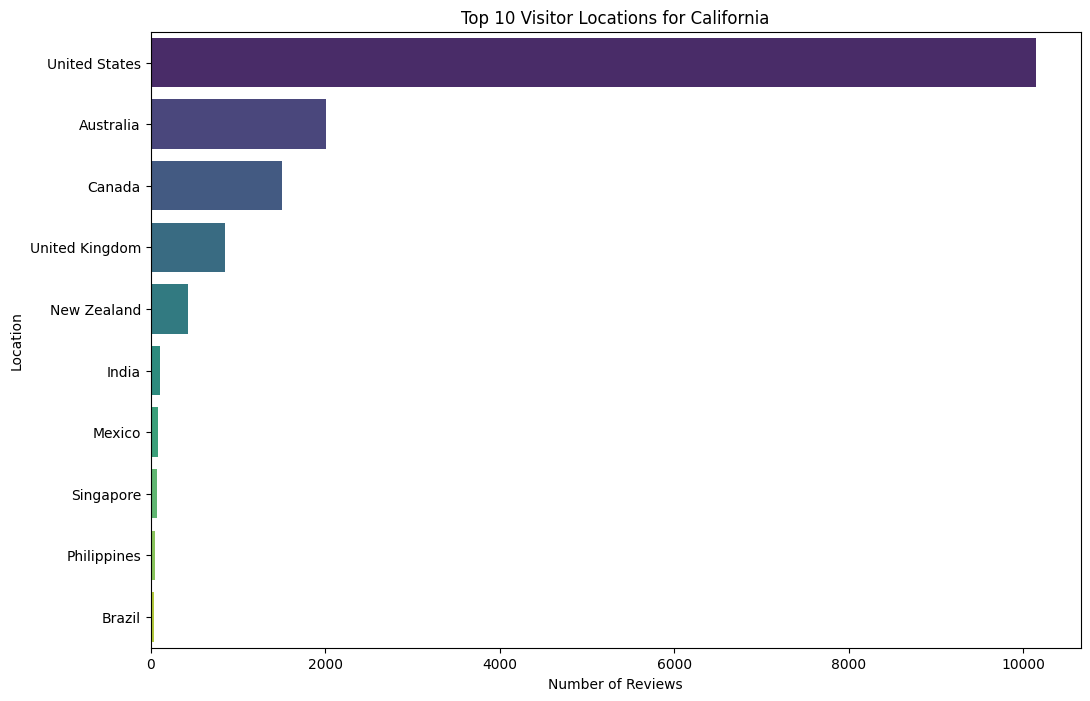

/tmp/ipython-input-3957764969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Reviewer_Location', data=data, palette='viridis')


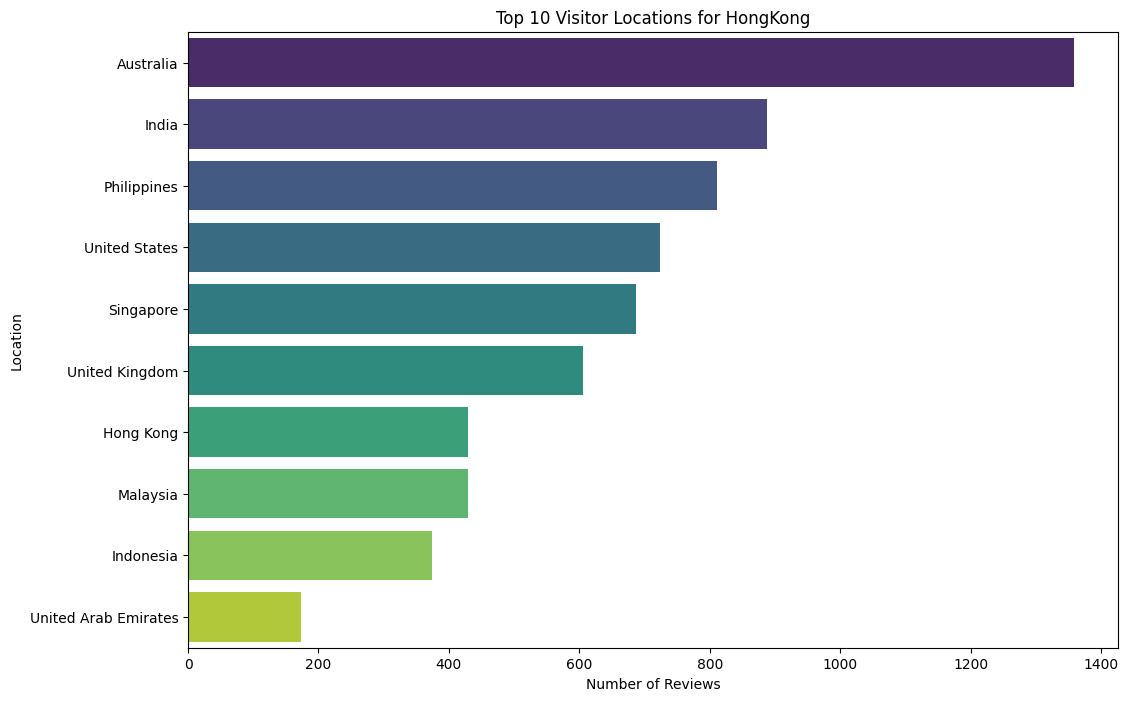

/tmp/ipython-input-3957764969.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Reviewer_Location', data=data, palette='viridis')


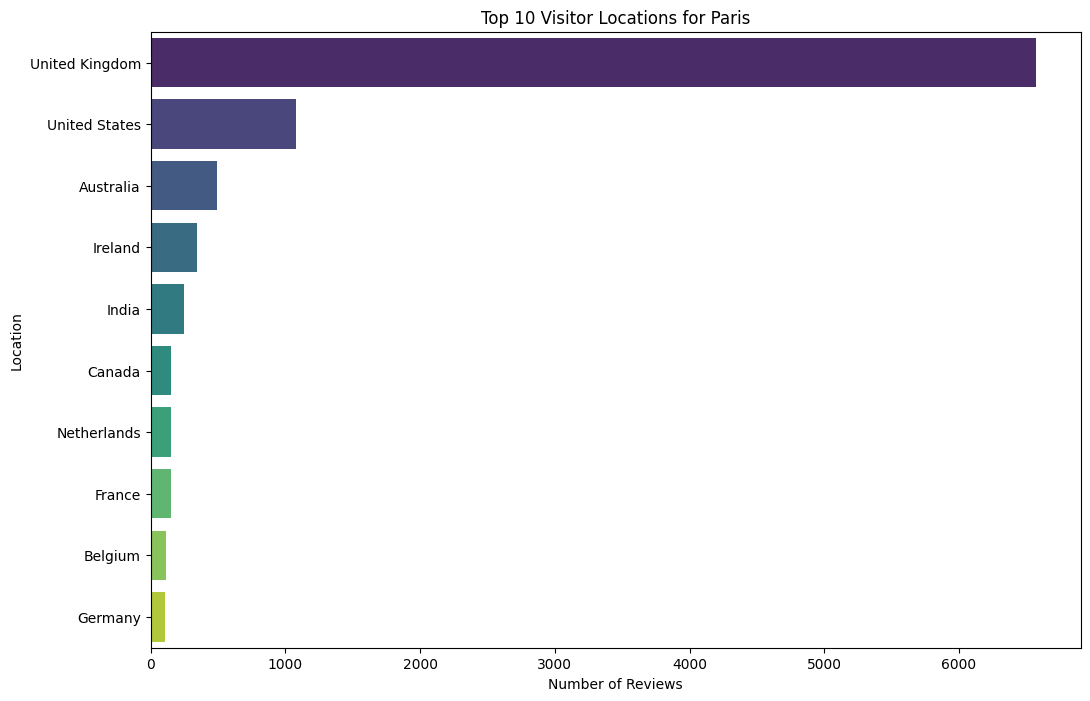

In [ ]:
# Group by branch and location, then count
visitor_counts = data.groupby(['Branch', 'Reviewer_Location']).size().reset_index(name='Count')

# Find top 10 visitor groups for each branch
top_10_visitors = visitor_counts.groupby('Branch').apply(lambda x: x.nlargest(10, 'Count')).reset_index(drop=True)

# Define a function to plot the top 10 locations for a given branch
def plot_top_10_visitors(branch_name):
    data = top_10_visitors[top_10_visitors['Branch'] == branch_name]

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Count', y='Reviewer_Location', data=data, palette='viridis')
    plt.title(f'Top 10 Visitor Locations for {branch_name}')
    plt.xlabel('Number of Reviews')
    plt.ylabel('Location')
    plt.show()

# Plot for each branch
branches = data['Branch'].unique()
for branch in branches:
    plot_top_10_visitors(branch)


###**Comparison and Analysis**

####**Top Visitor Groups:**
**Hong Kong:** Dominated by visitors from Australia, India, and the Philippines.

**Paris:** Predominantly visited by people from the United Kingdom, followed by the United States and Australia.

**California:** Mainly visited by people from the United States, with a significant number of visitors from Australia and Canada.

####**Branch-Specific Trends:**
The Hong Kong branch attracts a more diverse group from Asia-Pacific regions (e.g., Philippines, Malaysia, Indonesia).

The Paris branch has a strong European influence, with visitors from Ireland, Netherlands, France, Belgium, and Germany.

The California branch has a mix of North American (United States, Canada, Mexico), Oceania (Australia, New Zealand), and Asian (India, Singapore, Philippines) visitors.

####**Reasons for Differences:**
**Geographical Proximity:**
Visitors tend to come from nearby regions or countries with strong travel ties. For example, Hong Kong sees many visitors from Asia-Pacific, Paris from Europe, and California from North America.


In [ ]:
# Filter data for the California branch
california_data = data[data['Branch'] == 'California']
# Create a new column to classify visitor type
california_data['Visitor_Type'] = california_data['Reviewer_Location'].apply(
    lambda x: 'Domestic' if 'United States' in x else 'International'
)
california_data['Date'] = pd.to_datetime(california_data['Year_Month'], format='%Y-%m', errors='coerce')

# Extract month and year for peak analysis
california_data['Month'] = california_data['Date'].dt.month
california_data['Year'] = california_data['Date'].dt.year

/tmp/ipython-input-2360421772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_data['Visitor_Type'] = california_data['Reviewer_Location'].apply(
/tmp/ipython-input-2360421772.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  california_data['Date'] = pd.to_datetime(california_data['Year_Month'], format='%Y-%m', errors='coerce')
/tmp/ipython-input-2360421772.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

###**B. Peak Visiting Times Analysis for the California Branch**

We examine domestic vs. international visitors to identify any patterns

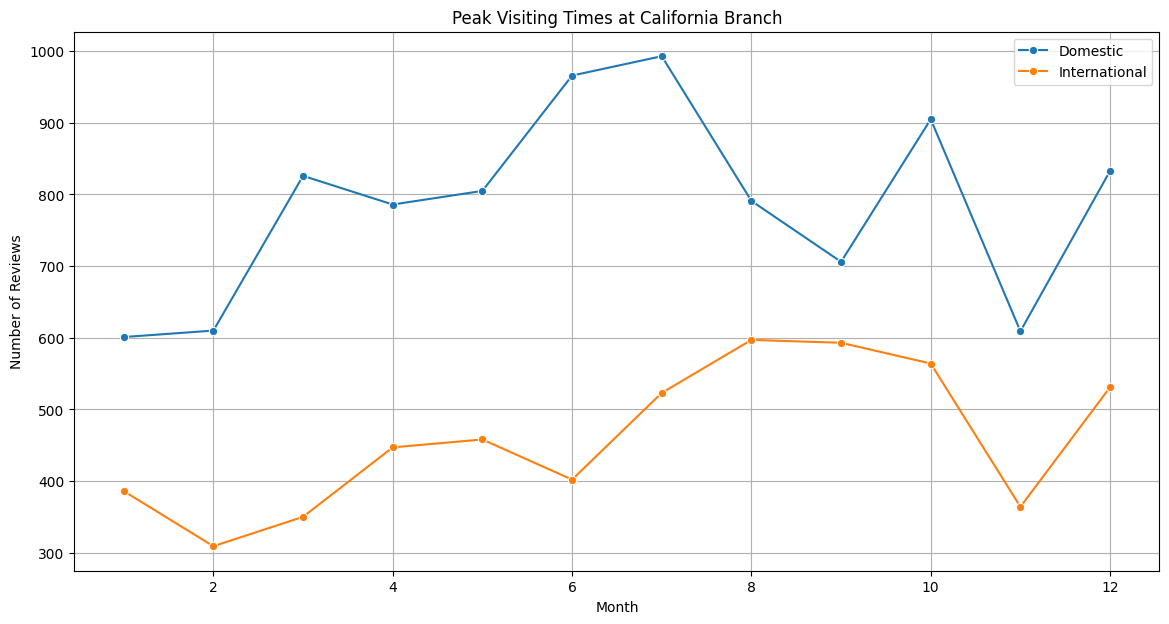

In [ ]:
# Group by Visitor_Type and Month to find peak visiting times
monthly_visits = california_data.groupby(['Visitor_Type', 'Month']).size().reset_index(name='Review_Count')
plt.figure(figsize=(14, 7))

# Plot for domestic visitors
sns.lineplot(data=monthly_visits[monthly_visits['Visitor_Type'] == 'Domestic'], x='Month', y='Review_Count', label='Domestic', marker='o')

# Plot for international visitors
sns.lineplot(data=monthly_visits[monthly_visits['Visitor_Type'] == 'International'], x='Month', y='Review_Count', label='International', marker='o')

plt.title('Peak Visiting Times at California Branch')
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.legend()
plt.grid(True)
plt.show()



**Domestic Visitors:**
- **Peak Months:** March, June, July, October.
- **Trough Months:** February, September, November.

**International Visitors:**
- **Peak Months:** April, August, December.
- **Trough Months:** February, June, October.

**Key Differences:**
- **Seasonal Influence:** Domestic peaks during summer and holidays; international peaks during spring, late summer, and winter.
- **Vacation Periods:** Domestic trips align with school breaks; international visits align with major holidays.



<a id = "cell_sentiment"></a>
# 3. Sentiment Analysis

**Aim:** To analyze and compare customer sentiments towards theme parks and assess sentiments related to "services."


###C. Comparison of Overall Sentiments Expressed by Customers


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [word.lower() for word in tokens]

    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    # Joining tokens back into a string
    return ' '.join(tokens)

# Apply preprocessing to the Review_Text column
data['Cleaned_Review_Text'] = data['Review_Text'].apply(preprocess_text)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


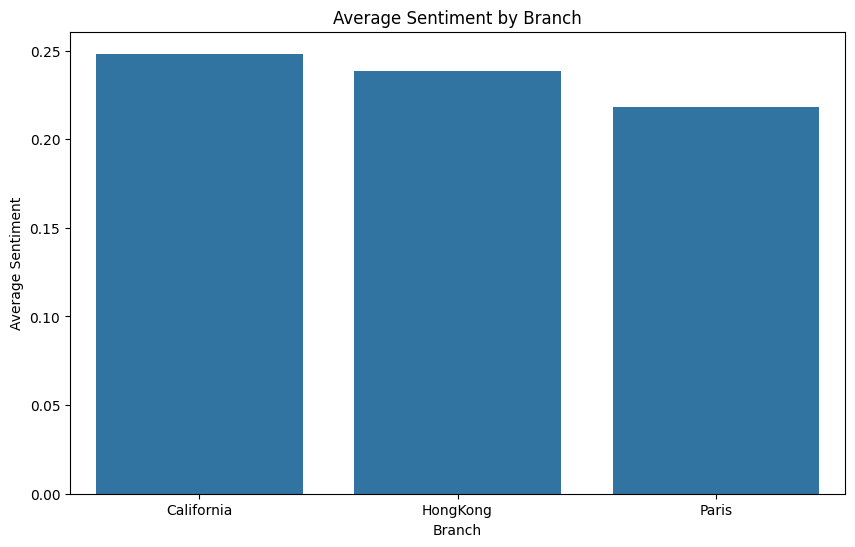

In [ ]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

data['Sentiment'] = data['Cleaned_Review_Text'].apply(get_sentiment)

# Compare average sentiment by branch
avg_sentiment = data.groupby('Branch')['Sentiment'].mean().reset_index()

# Visualize the sentiments
plt.figure(figsize=(10, 6))
sns.barplot(x='Branch', y='Sentiment', data=avg_sentiment)
plt.title('Average Sentiment by Branch')
plt.xlabel('Branch')
plt.ylabel('Average Sentiment')
plt.show()

###**Conclusion:**
**Overall Sentiment:** All three theme park branches have positive sentiment scores, indicating favorable customer experiences.

**Comparison:** The California branch has the highest average sentiment score, suggesting that customers are most satisfied with their experiences there. The Hong Kong branch follows closely, while the Paris branch has a slightly lower but still positive sentiment score.

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


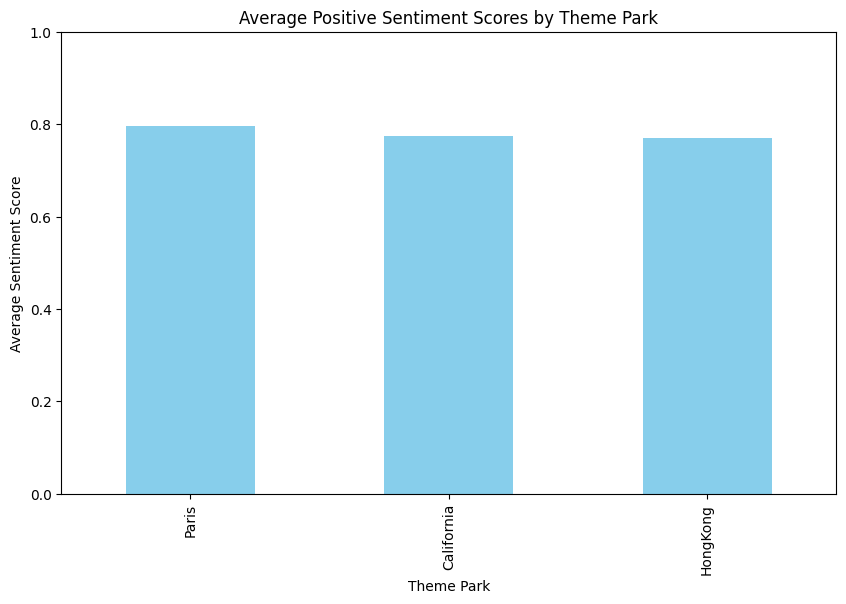

Overall Sentiments by Theme Park:
Branch
Paris         0.795605
California    0.774848
HongKong      0.770950
Name: Sentiment, dtype: float64


In [ ]:

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

data['Sentiment'] = data['Cleaned_Review_Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

data_positive = data[data['Sentiment'] > 0]

# Aggregate sentiment scores for each theme park
theme_park_sentiments = data_positive.groupby('Branch')['Sentiment'].mean().sort_values(ascending=False)

# Plotting the graph
plt.figure(figsize=(10, 6))
theme_park_sentiments.plot(kind='bar', color='skyblue')
plt.title('Average Positive Sentiment Scores by Theme Park')
plt.xlabel('Theme Park')
plt.ylabel('Average Sentiment Score')
plt.ylim(0, 1)  # Only positive scores are considered
plt.show()

# Display the results
print("Overall Sentiments by Theme Park:")
print(theme_park_sentiments)


###**Insights:**

**Overall Sentiment:** All three theme park branches have high positive sentiment scores, indicating a generally positive customer experience across the board.

**Comparison:**
This suggests that customers are highly satisfied with their experiences at all three theme park branches, with only minor variations in sentiment.

###**D. Most Positive Sentiment for "Services"**


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/tmp/ipython-input-1479393637.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_positive['Services_Sentiment'] = data_positive['Cleaned_Review_Text'].apply(


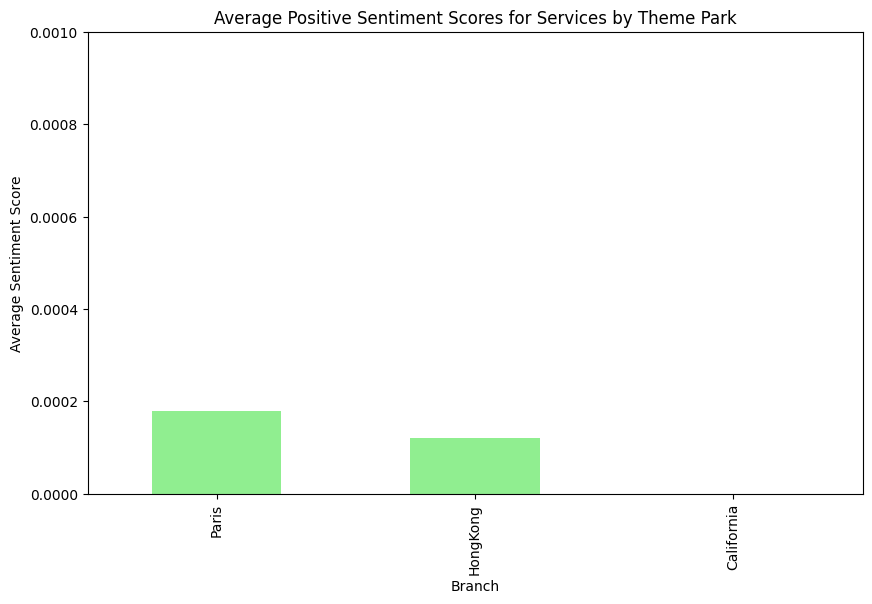


Sentiments for 'Services' by Theme Park:
Branch
Paris         0.000179
HongKong      0.000121
California    0.000000
Name: Services_Sentiment, dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize
from statistics import mean
import nltk

# Download required NLTK resources
nltk.download('vader_lexicon')

# Initialize SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Define the aspect_sentiment function
def aspect_sentiment(aspect, sents, scores):
    AspSen = []
    for s in range(len(sents)):
        if aspect in sents[s].lower():  # Ensure case-insensitive matching
            AspSen.append(scores[s]['compound'])
    return round(mean(AspSen), 3) if AspSen else 0

# Compute sentiment scores for all reviews
data['Sentiment'] = data['Cleaned_Review_Text'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Filter out only positive sentiment scores
data_positive = data[data['Sentiment'] > 0]

# Compute sentiment for specific aspect "services"
data_positive['Services_Sentiment'] = data_positive['Cleaned_Review_Text'].apply(
    lambda x: aspect_sentiment('services', sent_tokenize(x),
                               [sid.polarity_scores(sent) for sent in sent_tokenize(x)])
)

# Aggregate sentiment scores for 'services' by branch
services_sentiments_by_branch = data_positive.groupby('Branch')['Services_Sentiment'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
services_sentiments_by_branch.plot(kind='bar', color='lightgreen')
plt.title('Average Positive Sentiment Scores for Services by Theme Park')
plt.xlabel('Branch')
plt.ylabel('Average Sentiment Score')
plt.ylim(0, 0.001)  # Only positive scores are considered
plt.show()

# Display the results
print("\nSentiments for 'Services' by Theme Park:")
print(services_sentiments_by_branch)


The theme park branch that received the most positive sentiment for their “services” is Paris, with a sentiment score of 0.000179.

<a id = "cell_TopicModeling"></a>
## **4. Topic Modeling**
Aim: The aim of topic modeling is to identify and extract key themes or topics from a collection of text data.

###E. What Are the Concerns or Interests of Customers When Visiting the Theme Parks?

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')

def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Lowercasing
    tokens = [word.lower() for word in tokens]

    # Removing punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # POS Tagging
    tagged_tokens = pos_tag(tokens)
    # Extract only nouns
    nouns = [word for word, pos in tagged_tokens if pos.startswith('NN')]

    # Stemming
    stemmer = PorterStemmer()
    nouns = [stemmer.stem(word) for word in nouns]

    return ' '.join(nouns)


data['Text'] = data['Cleaned_Review_Text'].apply(preprocess_text)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


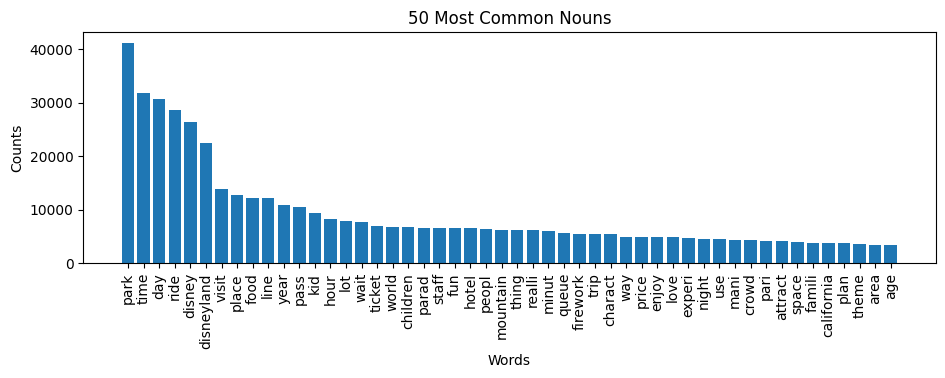

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.95, min_df=2)

dtm = count_vectorizer.fit_transform(data['Text'])

terms = count_vectorizer.get_feature_names_out()

total_counts = np.zeros(len(terms))

for t in dtm:
    total_counts += t.toarray()[0]

count_dict = list(zip(terms, total_counts))

count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[:50]

words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

# Plot the top 50 words
plt.figure(figsize=(11, 3))
plt.bar(words, counts)
plt.xticks(x_pos, words, rotation=90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('50 Most Common Nouns')
plt.show()

In [ ]:
terms = count_vectorizer.get_feature_names_out()


total_counts = np.asarray(dtm.sum(axis=0)).flatten()

# Define frequency limits
threshold_high = 20000
threshold_low = 100

# Filter indices based on thresholds
keepIndex = [t for t in range(len(total_counts)) if total_counts[t] < threshold_high and total_counts[t] > threshold_low]

print('Number of Terms Remained: ', len(keepIndex))

ReducedTerm = [terms[t] for t in keepIndex]

ReducedCount = dtm[:, keepIndex]

reduced_df = pd.DataFrame(ReducedCount.toarray(), columns=ReducedTerm)
print(reduced_df.head())

Number of Terms Remained:  1191
   abl  absolut  access  accommod  act  action  activ  ad  add  addit  ...  \
0    0        0       0         0    0       0      0   0    0      0  ...   
1    0        0       0         0    0       0      0   0    0      0  ...   
2    0        0       0         0    0       0      0   0    0      0  ...   
3    0        0       0         0    0       0      0   0    0      0  ...   
4    0        0       0         0    0       0      0   0    0      0  ...   

   worri  worth  wow  xma  ye  year  yesterday  york  yr  zone  
0      0      0    0    0   0     0          0     0   0     0  
1      0      0    0    0   0     0          0     0   0     0  
2      0      0    0    0   0     0          0     0   0     0  
3      0      0    0    0   0     0          0     0   0     0  
4      0      0    0    0   0     0          0     0   0     0  

[5 rows x 1191 columns]


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

number_topics = 6

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=2023)
lda.fit(ReducedCount)

lda.components_

array([[7.06591883e+02, 1.13159085e+02, 1.75652663e+02, ...,
        1.67190128e-01, 7.47254987e+01, 1.67550906e-01],
       [1.82050895e+02, 1.10213405e+02, 1.92255656e+02, ...,
        1.66907117e-01, 1.20720592e+02, 3.67097530e+01],
       [8.72667835e+01, 4.72142857e+02, 1.72676456e+01, ...,
        2.55851585e+01, 7.94676359e+01, 3.85993362e+00],
       [1.45633354e+02, 1.37020051e+02, 6.30356348e+02, ...,
        1.88743407e+02, 8.81173307e+01, 4.95206575e+01],
       [1.66847582e+02, 5.13625971e+01, 9.23644293e+01, ...,
        1.70239911e-01, 1.15272141e+01, 1.98686034e+01],
       [8.46095027e+01, 3.21020044e+01, 3.71032576e+01, ...,
        1.67097482e-01, 3.54417289e+01, 3.58735016e+01]])

In [ ]:
Word_Topics_Pro = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]
print(Word_Topics_Pro)

[[4.12274475e-03 6.60248206e-04 1.02487888e-03 ... 9.75502603e-07
  4.36000136e-04 9.77607635e-07]
 [1.39242846e-03 8.42974605e-04 1.47048025e-03 ... 1.27660025e-06
  9.23339525e-04 2.80777002e-04]
 [6.99853158e-04 3.78644263e-03 1.38481285e-04 ... 2.05185218e-04
  6.37306358e-04 3.09554979e-05]
 [7.23030512e-04 6.80267776e-04 3.12955007e-03 ... 9.37060353e-04
  4.37478894e-04 2.45856772e-04]
 [1.39571438e-03 4.29658702e-04 7.72647473e-04 ... 1.42409192e-06
  9.64275199e-05 1.66204960e-04]
 [8.40670047e-04 3.18961732e-04 3.68653595e-04 ... 1.66026088e-06
  3.52144841e-04 3.56434883e-04]]


In [ ]:
for topic_idx, topic in enumerate(Word_Topics_Pro):
    print("\nTopic #%d:" % topic_idx)
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:5]
    for w in count_dict:
        print(w[0], ': {0:.3f}'.format(w[1]))


Topic #0:
line : 0.050
pass : 0.036
year : 0.026
visit : 0.023
place : 0.020

Topic #1:
place : 0.039
kid : 0.035
visit : 0.029
parad : 0.022
firework : 0.021

Topic #2:
food : 0.031
staff : 0.021
year : 0.020
visit : 0.019
parad : 0.019

Topic #3:
hotel : 0.024
queue : 0.015
staff : 0.014
hour : 0.014
children : 0.013

Topic #4:
mountain : 0.049
space : 0.029
world : 0.021
thunder : 0.015
star : 0.014

Topic #5:
food : 0.052
water : 0.023
price : 0.018
ticket : 0.017
lot : 0.016


In [ ]:
df_topic_keywords = pd.DataFrame(Word_Topics_Pro)
df_topic_keywords.columns = ReducedTerm
df_topic_keywords

,abl,absolut,access,accommod,act,action,activ,ad,add,addit,...,worri,worth,wow,xma,ye,year,yesterday,york,yr,zone
0,0.004123,0.000660,0.001025,0.000360,0.000415,0.000022,0.000195,0.000540,0.000105,0.000540,...,0.000245,0.001657,0.000377,9.758741e-07,0.002294,0.026181,0.000353,9.755026e-07,0.000436,9.776076e-07
1,0.001392,0.000843,0.001470,0.000001,0.000182,0.000003,0.001142,0.000587,0.000174,0.000457,...,0.000362,0.001912,0.000726,1.277521e-06,0.000722,0.009183,0.000077,1.276600e-06,0.000923,2.807770e-04
2,0.000700,0.003786,0.000138,0.000154,0.000038,0.000420,0.000123,0.000770,0.000050,0.000124,...,0.000317,0.002561,0.001084,8.995157e-04,0.002378,0.019553,0.000002,2.051852e-04,0.000637,3.095550e-05
3,0.000723,0.000680,0.003130,0.000633,0.000187,0.000450,0.000071,0.000393,0.000158,0.000293,...,0.000365,0.000426,0.000109,8.312689e-07,0.000798,0.007995,0.000120,9.370604e-04,0.000437,2.458568e-04
4,0.001396,0.000430,0.000773,0.000027,0.000095,0.000387,0.000133,0.000985,0.000086,0.001219,...,0.000125,0.000511,0.000152,1.401892e-06,0.000630,0.005047,0.000088,1.424092e-06,0.000096,1.662050e-04
5,0.000841,0.000319,0.000369,0.000013,0.000003,0.000363,0.000265,0.000384,0.000158,0.001078,...,0.000086,0.001598,0.000002,1.663232e-06,0.001102,0.005539,0.000105,1.660261e-06,0.000352,3.564349e-04


In [ ]:
TopicDis_Doc = lda.transform(ReducedCount)

Overall_Topic_Dis = sum(TopicDis_Doc)/sum(sum(TopicDis_Doc))
Overall_Topic_Dis

array([0.22891535, 0.2059232 , 0.18379689, 0.15087271, 0.114635  ,
       0.11585684])

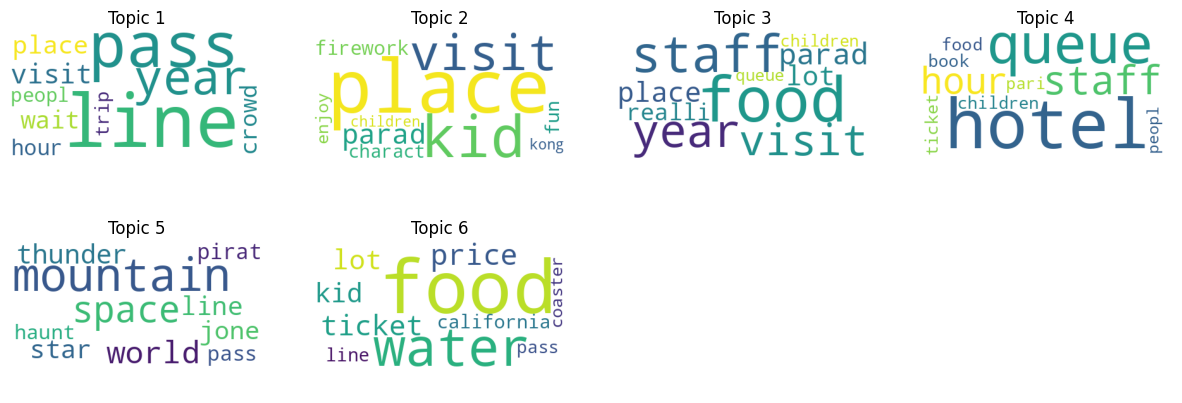

In [ ]:
!pip install wordcloud

from wordcloud import WordCloud
import math
rows = math.ceil(len(Word_Topics_Pro)/4)
fig, ax = plt.subplots(rows, 4, figsize=(15,2.5*rows))
[axi.set_axis_off() for axi in ax.ravel()]
for topic_idx, topic in enumerate(Word_Topics_Pro):
    count_dict = (zip(ReducedTerm, topic))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)

    Word_Frequency = dict(count_dict[0:10])
    # generate word cloud
    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)
    # visualize word cloud in figure
    subfig_Row = math.floor(topic_idx/4)
    subfig_Col = math.ceil(topic_idx%4)
    ax[subfig_Row,subfig_Col].imshow(wordcloud)
    ax[subfig_Row,subfig_Col].set_title("Topic {}".format(topic_idx+1))
plt.show()

**Key Themes:**
1. **Wait Times and Queue Management:** Significant concern due to mentions of "line," "wait," and "queue."
2. **Family and Child-Friendly Experiences:** Focus on "kid," "children," and "family" indicates interest in family-oriented attractions.
3. **Staff and Service Quality:** Importance highlighted by mentions of "staff."
4. **Food and Beverage:** Quality and variety of food are crucial.
5. **Attractions and Entertainment:** Keywords like "firework" and "coaster" show the importance of engaging attractions.
6. **Ticketing and Pricing:** Considerations around "ticket," "price," and "pass" suggest value for money is key.

**Conclusion:** Successful parks should focus on efficient queue management, family-centric offerings, high-quality customer service, diverse dining options, engaging attractions, and fair pricing.


In [ ]:
TopicDis_Doc = lda.transform(ReducedCount)
df_document_topics = pd.DataFrame(TopicDis_Doc)
df_document_topics

,0,1,2,3,4,5
0,0.500305,0.009853,0.222901,0.247157,0.009926,0.009857
1,0.033777,0.831015,0.033889,0.034004,0.033718,0.033597
2,0.422883,0.529094,0.012047,0.011995,0.011992,0.011989
3,0.003013,0.600193,0.150908,0.003024,0.003007,0.239855
4,0.009372,0.009407,0.009347,0.009351,0.009314,0.953209
...,...,...,...,...,...,...
34995,0.008838,0.254007,0.008824,0.008897,0.008837,0.710597
34996,0.018901,0.018945,0.906086,0.018827,0.018619,0.018622
34997,0.002814,0.002800,0.661070,0.327721,0.002799,0.002796
34998,0.754216,0.189605,0.014078,0.014029,0.014023,0.014048


/tmp/ipython-input-467632334.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


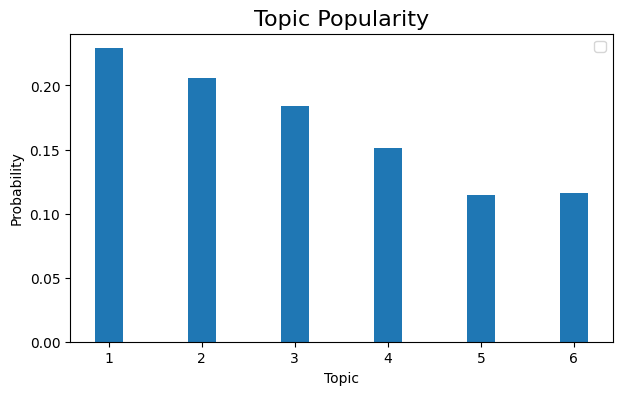

In [ ]:
Bar_index = np.asarray(range(1,number_topics+1))

#Visualize topic popularity
plt.figure(figsize=(7,4))
plt.title('Topic Popularity', fontsize=16)
plt.xlabel('Topic')
plt.ylabel('Probability')
plt.bar(Bar_index, Overall_Topic_Dis.tolist(), 0.3)
plt.xticks(Bar_index, Bar_index)
plt.legend()
plt.show();

In [ ]:
import gensim
import gensim.corpora as corpora

# Step 1: Convert cleaned text column into tokens
Cleaned_doc_new = data['Cleaned_Review_Text'].apply(lambda x: x.split())

# Step 2: Create dictionary
id2word = corpora.Dictionary(Cleaned_doc_new)

# Step 3: Create corpus (term-document frequency)
corpus = [id2word.doc2bow(text) for text in Cleaned_doc_new]

# Step 4: Build LDA Model
lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=5,
    random_state=42,
    update_every=1,
    chunksize=100,
    passes=10,
    alpha='auto'
)

# Step 5: View the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx}: {topic}")


Topic 0: 0.030*"food" + 0.028*"hotel" + 0.020*"fast" + 0.019*"ticket" + 0.018*"pass" + 0.017*"get" + 0.016*"restaur" + 0.015*"take" + 0.015*"use" + 0.014*"stay"
Topic 1: 0.032*"ride" + 0.030*"queue" + 0.024*"get" + 0.021*"wait" + 0.016*"n't" + 0.016*"hour" + 0.016*"time" + 0.015*"day" + 0.015*"peopl" + 0.015*"2"
Topic 2: 0.077*"mountain" + 0.046*"space" + 0.038*"thunder" + 0.036*"pirat" + 0.032*"star" + 0.028*"buzz" + 0.021*"tour" + 0.021*"pan" + 0.021*"jone" + 0.021*"peter"
Topic 3: 0.036*"park" + 0.028*"disney" + 0.018*"ride" + 0.017*"time" + 0.014*"disneyland" + 0.014*"day" + 0.014*"'s" + 0.013*"visit" + 0.012*"go" + 0.011*"n't"
Topic 4: 0.049*"staff" + 0.021*"smoke" + 0.019*"french" + 0.019*"servic" + 0.018*"member" + 0.012*"seem" + 0.012*"cast" + 0.011*"rude" + 0.010*"poor" + 0.010*"guest"


In [ ]:
Corpus = [id2word.doc2bow(text) for text in Cleaned_doc_new]


In [ ]:
import gensim
from gensim.models.ldamodel import LdaModel
from pprint import pprint

lda_model = gensim.models.ldamodel.LdaModel(corpus=Corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       random_state=100)

pprint(lda_model.print_topics(num_words=10))
doc_lda = lda_model[Corpus]

[(0,
  '0.042*"park" + 0.037*"disney" + 0.028*"ride" + 0.022*"pari" + '
  '0.021*"disneyland" + 0.017*"visit" + 0.012*"mountain" + 0.011*"\'s" + '
  '0.010*"attract" + 0.010*"world"'),
 (1,
  '0.022*"park" + 0.019*"staff" + 0.013*"disney" + 0.012*"time" + 0.011*"n\'t" '
  '+ 0.011*"ride" + 0.011*"peopl" + 0.010*"queue" + 0.009*"would" + '
  '0.008*"visit"'),
 (2,
  '0.289*"..." + 0.160*".." + 0.074*"...." + 0.022*"....." + 0.009*"......" + '
  '0.006*"emot" + 0.005*"disneyland" + 0.005*"visit" + 0.005*"asian" + '
  '0.004*"disney"'),
 (3,
  '0.030*"\'s" + 0.029*"disney" + 0.029*"n\'t" + 0.017*"park" + 0.011*"go" + '
  '0.009*"get" + 0.009*"one" + 0.008*"like" + 0.007*"thing" + 0.007*"\'re"'),
 (4,
  '0.023*"euro" + 0.020*"disney" + 0.019*"park" + 0.017*"ticket" + '
  '0.015*"charact" + 0.015*"queue" + 0.010*"would" + 0.009*"mickey" + '
  '0.008*"studio" + 0.008*"shop"'),
 (5,
  '0.028*"place" + 0.017*"show" + 0.017*"parad" + 0.017*"love" + '
  '0.016*"disneyland" + 0.014*"ride" + 0.014

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=Cleaned_doc_new,
                                     dictionary=id2word,
                                     coherence='c_v')


coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3190061362811637


In [ ]:
Topics = list(range(2,31,1))
coherence_scores = []
Trained_Models = []
for top in Topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=Corpus,
                                               id2word=id2word,
                                               num_topics=top,
                                               random_state=100)
    Trained_Models.append(lda_model)

    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=Cleaned_doc_new,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

    coherence_scores.append(coherence)
    print('Topic Number: {0} -- Coherence: {1}'.format(top, coherence))

Topic Number: 2 -- Coherence: 0.29435953158042905
Topic Number: 3 -- Coherence: 0.2989917761638576
Topic Number: 4 -- Coherence: 0.314694002354027
Topic Number: 5 -- Coherence: 0.31956010167508736
Topic Number: 6 -- Coherence: 0.3104900915352758
Topic Number: 7 -- Coherence: 0.3375497111949585
Topic Number: 8 -- Coherence: 0.32425388669296895
Topic Number: 9 -- Coherence: 0.3225123650798929
Topic Number: 10 -- Coherence: 0.3190061362811637
Topic Number: 11 -- Coherence: 0.3451978491362964
Topic Number: 12 -- Coherence: 0.3505502533800608
Topic Number: 13 -- Coherence: 0.35777526020860156
Topic Number: 14 -- Coherence: 0.34475009384949423
Topic Number: 15 -- Coherence: 0.348115303247989
Topic Number: 16 -- Coherence: 0.3633656599002545
Topic Number: 17 -- Coherence: 0.35553415465755045
Topic Number: 18 -- Coherence: 0.38267298954977
Topic Number: 19 -- Coherence: 0.3546534002623438
Topic Number: 20 -- Coherence: 0.3457856634099788
Topic Number: 21 -- Coherence: 0.36785513024983263
Topic

Text(0, 0.5, 'Coherence')

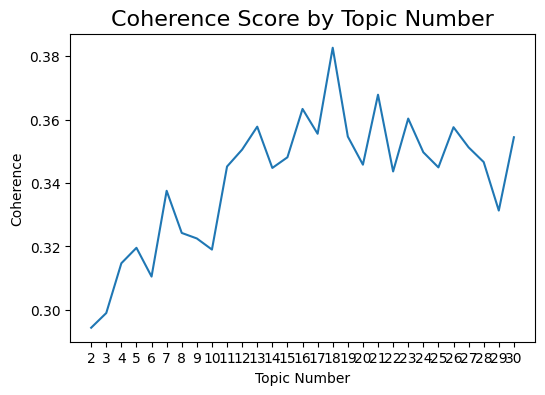

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(coherence_scores)
plt.xticks(range(0,len(Topics)),Topics)
plt.title('Coherence Score by Topic Number', fontsize=16)
plt.xlabel('Topic Number')
plt.ylabel('Coherence')

###E: Differences in concerns and interests between visitors from the United States and the United Kingdom

In [ ]:
dtm_df = pd.DataFrame(dtm.toarray(), columns=terms)

combined_df = pd.concat([data[['Reviewer_Location', 'Text']], dtm_df], axis=1)
# Separate the data into U.S. and U.K. reviews
us_data = combined_df[combined_df['Reviewer_Location'] == 'United States']
uk_data = combined_df[combined_df['Reviewer_Location'] == 'United Kingdom']


In [ ]:
print(us_data.head())
print(uk_data.head())

  Reviewer_Location                                               Text  00  \
0     United States  see light park crowd disneyland mani time expe...   0   
1     United States            review disneyland day day kid love cour   0   
2     United States  day midnight love offer time wait line meet ch...   0   
4     United States  place kid wife thing park pack price food park...   0   
6     United States  teenag time comment expect meal park crowd wee...   0   

   10  11  12  13  14  15  16  ...  ziploc  ziplock  zipper  zocalo  zombi  \
0   0   0   0   0   0   0   0  ...       0        0       0       0      0   
1   0   0   0   0   0   0   0  ...       0        0       0       0      0   
2   0   0   0   0   0   0   0  ...       0        0       0       0      0   
4   0   0   0   0   0   0   0  ...       0        0       0       0      0   
6   0   0   0   0   0   0   0  ...       0        0       0       0      0   

   zone  zoo  zoom  zootopia  zurg  
0     0    0     0       

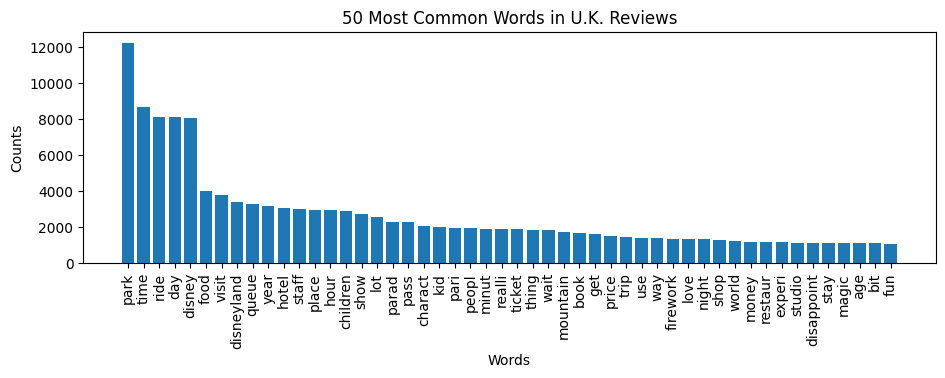

In [ ]:
count_vectorizer = CountVectorizer()
uk_dtm = count_vectorizer.fit_transform(uk_data['Text'])

terms = count_vectorizer.get_feature_names_out()

total_counts = np.zeros(len(terms))
for t in uk_dtm:
    total_counts += t.toarray()[0]

count_dict = list(zip(terms, total_counts))

count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[:50]

words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

plt.figure(figsize=(11, 3))
plt.bar(words, counts)
plt.xticks(x_pos, words, rotation=90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('50 Most Common Words in U.K. Reviews')
plt.show()

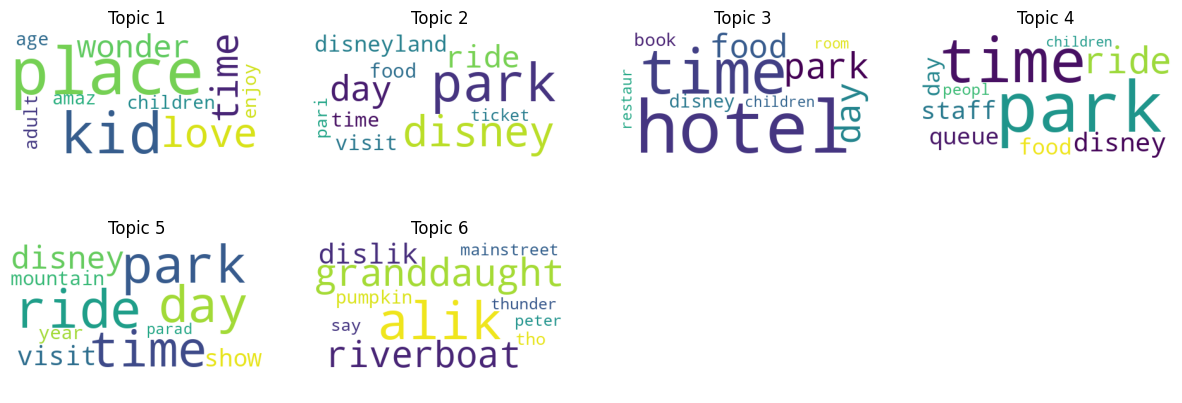

In [ ]:
number_topics = 6

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=2023)
lda.fit(uk_dtm)

Word_Topics_Pro = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

rows = math.ceil(len(Word_Topics_Pro) / 4)
fig, ax = plt.subplots(rows, 4, figsize=(15, 2.5 * rows))
[axi.set_axis_off() for axi in ax.ravel()]

for topic_idx, topic in enumerate(Word_Topics_Pro):
    count_dict = zip(count_vectorizer.get_feature_names_out(), topic)
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)

    Word_Frequency = dict(count_dict[:10])

    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)

    subfig_Row = math.floor(topic_idx / 4)
    subfig_Col = topic_idx % 4
    ax[subfig_Row, subfig_Col].imshow(wordcloud)
    ax[subfig_Row, subfig_Col].set_title(f"Topic {topic_idx + 1}")

plt.show()

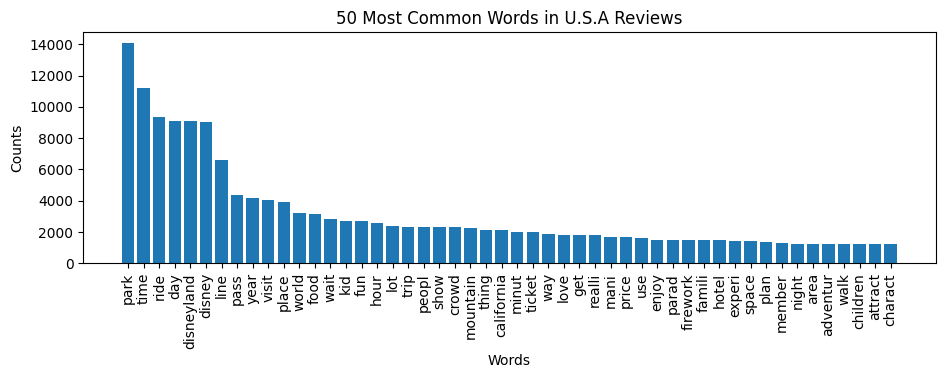

In [ ]:
count_vectorizer = CountVectorizer()
us_dtm = count_vectorizer.fit_transform(us_data['Text'])

terms = count_vectorizer.get_feature_names_out()

total_counts = np.zeros(len(terms))
for t in us_dtm:
    total_counts += t.toarray()[0]

count_dict = list(zip(terms, total_counts))

count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)[:50]

words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words))

plt.figure(figsize=(11, 3))
plt.bar(words, counts)
plt.xticks(x_pos, words, rotation=90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('50 Most Common Words in U.S.A Reviews')
plt.show()

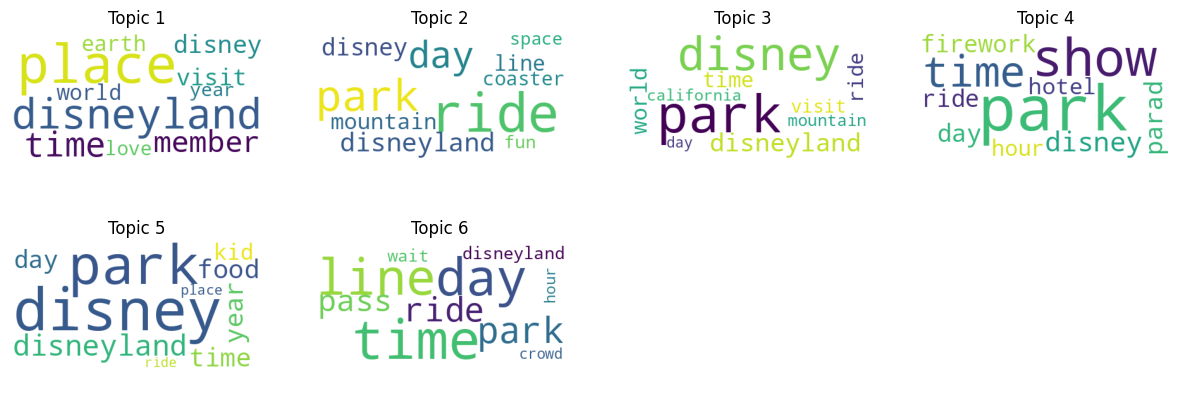

In [ ]:
number_topics = 6

lda = LDA(n_components=number_topics, n_jobs=-1, random_state=2023)
lda.fit(us_dtm)

Word_Topics_Pro = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

rows = math.ceil(len(Word_Topics_Pro) / 4)
fig, ax = plt.subplots(rows, 4, figsize=(15, 2.5 * rows))
[axi.set_axis_off() for axi in ax.ravel()]

for topic_idx, topic in enumerate(Word_Topics_Pro):
    count_dict = zip(count_vectorizer.get_feature_names_out(), topic)
    count_dict = sorted(count_dict, key=lambda x: x[1], reverse=True)

    Word_Frequency = dict(count_dict[:10])

    wordcloud = WordCloud(background_color="white").generate_from_frequencies(Word_Frequency)

    subfig_Row = math.floor(topic_idx / 4)
    subfig_Col = topic_idx % 4
    ax[subfig_Row, subfig_Col].imshow(wordcloud)
    ax[subfig_Row, subfig_Col].set_title(f"Topic {topic_idx + 1}")

plt.show()

**UK vs. USA Differences:**
- **UK Reviews:** Focus on "queue," "staff," and "family."
- **USA Reviews:** Emphasis on "line," "wait," and specific attractions.

**Reasons for Differences:**
- **Cultural Expectations:** Different service and family focus.
- **Familiarity with Parks:** US visitors may be more accustomed to park logistics.
- **Demographics and Travel Habits:** Influence review content and focus.



# Practical Implications and Recommendations

**1. Efficient Queue Management:**
   - Implement fast pass systems and real-time updates.
   - Consider virtual queues to reduce wait times.

**2. Family-Centric Offerings:**
   - Enhance family areas and increase character interactions.
   - Offer family packages with discounts.

**3. High-Quality Customer Service:**
   - Invest in staff training and implement feedback systems.
   - Recognize and reward positive staff performance.

**4. Diverse Dining Options:**
   - Provide varied menu options and healthy choices.
   - Allow advanced dining reservations.
